In [1]:
# %pylab notebook
import numpy as np
import h5py
import matplotlib.pyplot as plt
import random
# %matplotlib ipympl

In [3]:
G3Xd = h5py.File('./data/G3X-profiles-progenitors_galrr.hdf5','r')
GIZd = h5py.File('./data/GIZ-profiles-progenitors_galrr.hdf5','r')

In [2]:
def cal_sta_profiles(mod,d,snap,region,bin25,ntclu,part = 0):
    nbin = 20
    rr = np.logspace(-1,3.5,nbin+1) #10^-1 ~ 10^3 kpc/h
    xx = (rr[1:] + rr[:-1]) / 2 #kpc/h
    area = np.pi*(rr)**2 #(kpc/h)^2
    # area = 4/3*np.pi*(rr)**3 #(kpc/h)^2
    area_diff = area[1:]-area[:-1]
    
    redshift = d['NewMDCLUSTER_0001/snap_%03d'%(snap)].attrs['redshift']
    
    rrall = [] #collect all radius data
    rrid = []
    total_Mste = []
    clu_id = []
    r200all = []
    
    Ngrp = 0
    for nclu in range(324):
        if 'Subhalo_rr2D' not in d['NewMDCLUSTER_0%03d/snap_%03d'%(nclu+1, snap)]:     
            continue
        r500 = d['NewMDCLUSTER_%04d/snap_%03d'%(nclu+1,snap)].attrs['r500']
        r200 = d['NewMDCLUSTER_%04d/snap_%03d'%(nclu+1,snap)].attrs['r200']
        rrsate = d['NewMDCLUSTER_%04d/snap_%03d/%s'%(nclu+1,snap,region)]
        stellar_mass = d['NewMDCLUSTER_%04d/snap_%03d/%s'%(nclu+1,snap,'Subhalo_stellarmass')][:]
        #selected satisfied galaxies
        idx = np.where(stellar_mass / 0.6777 > 10**10)[0] # Msun stellar mass selection
        r200all.extend([r200])
        clu_id.extend([nclu+1])
        
        if len(idx):
            total_Mste.extend([np.log10(np.sum(stellar_mass[idx]))])
            rrid.extend(np.tile(nclu+1, idx.shape[0]))
            rrall.extend(rrsate[idx])
            
            Ngrp+=1

    #total value
    print('Model and redshift:', mod, redshift)
    print('totol cluster number has 10^10 Msun/h:', Ngrp)
    print('median r200 in kpc/h', np.median(r200all))

    rrall = np.array(rrall)
    rrid = np.int64(rrid)
    Nsateall = rrall.shape[0]
    sta_gal,x0 = np.histogram(rrall, bins=rr)
    print(sta_gal.shape, area_diff.shape)
    
    xx = xx / 0.6777 #kpc
    yvalue = sta_gal / area_diff / ntclu * 0.6777**2 #kpc-2

    # # #bootstrap (100 times)
    nboot = 100
    count_clu_boot = np.zeros((nboot,nbin))
    for k in range(nboot):
        sel_cluid = random.choices(clu_id, k=ntclu)
        rr_boot = []
        for cid in sel_cluid:
            idx = np.where(rrid == cid)[0]
            if len(idx):
                rr_boot.extend(rrall[idx])
        rr_boot = np.array(rr_boot)
        num0,xn0 = np.histogram(rr_boot, bins=rr)
        count_clu_boot[k] = num0 / area_diff / ntclu * 0.6777**2
    
    yerror_perct = np.percentile(count_clu_boot,[16,84], axis = 0)
    print(yerror_perct.shape)
    yerror = np.std(count_clu_boot, axis = 0)

    print('three mass examples of galaxies', np.sort(total_Mste[-3:]))
    print('mean stellar mass of galaxies', np.mean(total_Mste))
    print('')

    return xx, yvalue, yerror_perct


In [51]:
# #calculate stellar mass limit from luminosity, based on Fig.8 in Cui+2018
# Mr = -20.5 #complete sample
# Msun = 4.65 #SDSS-r, AB
# Lh = 10**(0.4 * (Msun - Mr)) #Lsun
# print(np.log10(Lh))
# b = 7.05 - 0.895 * 9
# k = 0.895
# M_stellar_limit = (np.log10(Lh) - b) / k #Msun/h
# print('stellar mass limit for this sample log M*(Msun/h) is %.3f' %M_stellar_limit)

(10**(0.45 - 0.464*(-20.5))) / 1e9, np.sort([3,23,4])

(9.162204901219992, array([ 3,  4, 23]))

(61,) 1.69672131147541 1.7 0.3382535730923702


Text(0.5, 0, '$r_\\mathrm{p}\\ [\\mathrm{kpc}]$')

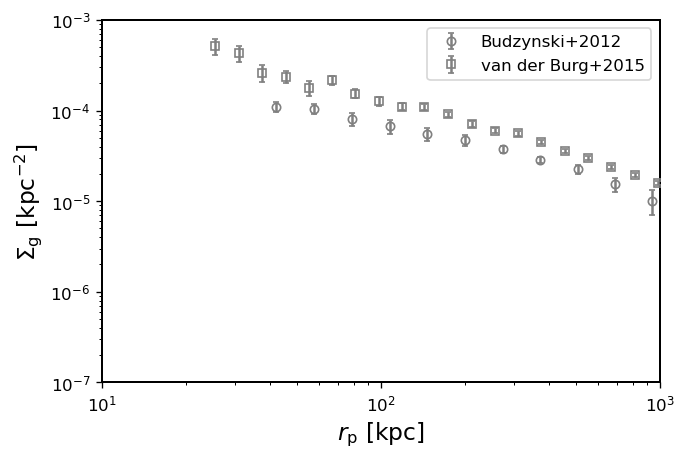

In [9]:
def ob_Numgal(ax):
    # plt.figure(dpi = 120)
    #===========================================================
    # #Budzynski+2012, Fig.5, 14.7-15.0 halo mass
    B2012_r_m = np.loadtxt(open('./data/ob_Numgal/Budzynski+2012/B_r_m.csv', 'r'),delimiter = ',')
    B2012_err_down = np.loadtxt(open('./data/ob_Numgal/Budzynski+2012/B2012_err_down.csv', 'r'),delimiter = ',')
    B2012_err_med = np.loadtxt(open('./data/ob_Numgal/Budzynski+2012/B2012_err_med.csv', 'r'),delimiter = ',')
    B2012_err_up = np.loadtxt(open('./data/ob_Numgal/Budzynski+2012/B2012_err_up.csv', 'r'),delimiter = ',')

    from scipy.interpolate import interp1d
    f_fit = interp1d(B2012_r_m[:,0], B2012_r_m[:,1], kind= 'quadratic',fill_value="extrapolate")
    xx = B2012_err_med[:,0] * 1e3
    yy = f_fit(B2012_err_med[:,0]) / 1e6
    yerr_down = (B2012_err_med[:,1]-B2012_err_down[:,1]) * (yy / B2012_err_med[:,1])
    yerr_up = (B2012_err_up[:,1]-B2012_err_med[:,1])* (yy / B2012_err_med[:,1])
    
    B2012 = ax.errorbar(xx, yy, yerr = [yerr_down, yerr_up] ,
                c = 'grey',fmt = 'o',mfc = 'none', label = 'Budzynski+2012'
                 ,ms = 5, zorder = 100, capsize = 2)
    
#     #===========================================================
#     #Shin+2021, Fig.5, Table 2, no parameters for rho_s
#     S2021_m = np.loadtxt(open('./data/ob_Numgal/Shin+2021/Shin_2021_m.csv', 'r'),delimiter = ',')
#     S2021_t = np.loadtxt(open('./data/ob_Numgal/Shin+2021/Shin_2021_up.csv', 'r'),delimiter = ',')
#     S2021_b = np.loadtxt(open('./data/ob_Numgal/Shin+2021/Shin_2021_down.csv', 'r'),delimiter = ',')
#     xx = S2021_m[:,0] * 1e3 / 0.7 #kpc
#     yy = S2021_m[:,1] / S2021_m[:,0] * 0.7**2 / 1e6 #kpc^-2
#     yerr_up = (S2021_t[:,1] - S2021_m[:,1]) / xx * 0.7**2 / 1e6
#     yerr_down = (S2021_m[:,1]-S2021_b[:,1]) / xx * 0.7**2 / 1e6
#     S2021 = ax.errorbar(xx, yy, yerr = [yerr_down, yerr_up],
#                 c = 'grey',fmt = '^',mfc = 'none', label = 'Shin+2021 (0.15 < z < 0.7)'
#                  ,ms = 5, zorder = 100, capsize = 2)
    
#     ax.legend(handles = [B2012, S2021],fontsize = 'x-small',loc = 2)
    
    #===========================================================
    #vdB+2015
    v2015_m = np.loadtxt(open('./data/ob_Numgal/vdB+2015/med.csv', 'r'),delimiter = ',')
    v2015_t = np.loadtxt(open('./data/ob_Numgal/vdB+2015/up.csv', 'r'),delimiter = ',')
    v2015_b = np.loadtxt(open('./data/ob_Numgal/vdB+2015/bot.csv', 'r'),delimiter = ',')
    r200 =  [2,2,1.9,1.7,1.8,2.2,1.9,2.0,1.9,2.1,1.4,1.6,1.3,1.4,1.9,1.7,1.6,1.5,1.7,1.6,1.5,1.5,1.9, 1.7,1.2,1.8,1.5,1.9,0.9,1.6,1.5,1.8,1.5,1.6,1.2,2.4,1.9,1.7,1.4,1.4,2.3,2.0,2.2,1.4,2.2,2.5,1.6,1.8,1.7, 2.3,1.7,1.6,1.3,1.4,1.9,1.4,1.2,0.9,1.8,1.3,1.9]
    r200 = np.array(r200)
    r200m = np.mean(r200) #Mpc
    # r200m = 2
    print(r200.shape, np.mean(r200), np.median(r200), np.std(r200))
    
    xx = v2015_m[:,0] * 1e3 * r200m #kpc
    yy = v2015_m[:,1] / r200m**2 / 1e6 #kpc^-2
    yerr_up = (v2015_t[:,1] - v2015_m[:,1]) / r200m**2 / 1e6
    yerr_down = (v2015_m[:,1] - v2015_b[:,1]) / r200m**2 / 1e6
    v2015 = ax.errorbar(xx, yy, yerr = [yerr_down, yerr_up],
                c = 'grey',fmt = 's',mfc = 'none', label = 'van der Burg+2015'
                 ,ms = 5, zorder = 100, capsize = 2)
    
    # def gNFW(xx, alpha, c):
    #     from astropy.cosmology import FlatLambdaCDM
    #     cosmo = FlatLambdaCDM(H0 = 70, Om0 = 0.3)
    #     pc = cosmo.critical_density(0).to('Msun Mpc-3').value
    #     rho0 = pc*200 / c**alpha / (1 + c)**(3-alpha)
    #     b1 = (xx*c)**alpha
    #     b2 = (1 + xx * c)**(3-alpha)
    #     return rho0 / b1 / b2
    # alpha = 1.64
    # c = 0.72
    # xx = np.logspace(-2,0,50)
    # yy = gNFW(xx, alpha, c)
    
    # L2011 = np.loadtxt(open('./data/ob_Numgal/Lares+2011/S0-A-a.csv', 'r'),delimiter = ',')
    # ax.plot(L2011[:,0], L2011[:,1]/1e6/0.7**2, 'r--')



plt.figure(dpi = 120)
ax = plt.gca()
ob_Numgal(ax)
plt.loglog()
plt.legend()
plt.xlim(1e1,1e3)
plt.ylim(0.1/1e6,1e-3)
plt.ylabel(r'$\Sigma_{\rm g}\ [\rm kpc^{-2}]$', fontsize = 14)
plt.xlabel(r'$r_\mathrm{p}\ [\mathrm{kpc}]$', fontsize = 14)

In [30]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0 = 70, Om0 = 0.3)
cosmo.critical_density(0).to('Msun Mpc-3')

<Quantity 1.35992947e+11 solMass / Mpc3>

Model and redshift: GIZ 0.0
totol cluster number has 10^10 Msun/h: 324
median r200 in kpc/h 1510.88
(20,) (20,)
(2, 20)
three mass examples of galaxies [12.51091737 12.51744757 12.66245913]
mean stellar mass of galaxies 12.754721839459942

Model and redshift: G3X 0.0
totol cluster number has 10^10 Msun/h: 324
median r200 in kpc/h 1523.125
(20,) (20,)
(2, 20)
three mass examples of galaxies [12.59044813 12.63585172 12.66734799]
mean stellar mass of galaxies 12.775122430739914

Model and redshift: GIZ 1.030549168586731
totol cluster number has 10^10 Msun/h: 324
median r200 in kpc/h 1206.1950000000002
(20,) (20,)
(2, 20)
three mass examples of galaxies [11.34789944 11.99090761 12.58354607]
mean stellar mass of galaxies 12.13452855780841

Model and redshift: G3X 1.030549168586731
totol cluster number has 10^10 Msun/h: 324
median r200 in kpc/h 1217.8899999999999
(20,) (20,)
(2, 20)
three mass examples of galaxies [11.54325636 11.938582   12.52178543]
mean stellar mass of galaxies 12.1005644

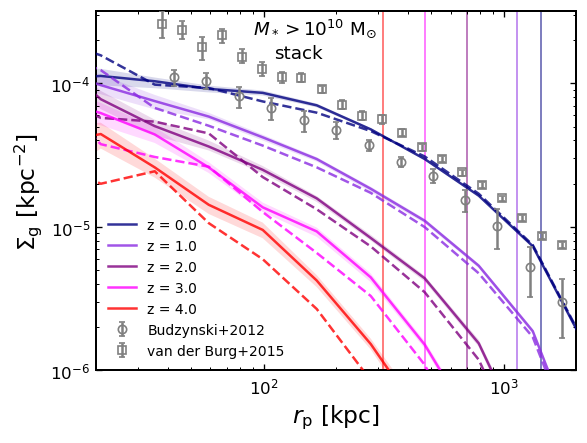

In [10]:
#Combined results
from astropy.cosmology import FlatLambdaCDM
plt.figure(figsize = (5,3.8), dpi = 120)
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.2 #set the value globally
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115)

snapb = [128,96,78,65,55,47,40]
redb = ['z = 0.0','z = 1.0','z = 2.0','z = 3.0','z = 4.0','z = 5.0','z = 6.0']
# colall = ['b','r','k','orange','cyan','magenta','green']
colall = ['navy','blueviolet','purple','magenta','r','tomato','orange']
nGIZ = [324,324,323,323,323,318,306]
nG3X = [324,324,324,323,323,320,305]
#==========================================================



# GIZMO
#Gadget-X      
for i in [0,1,2,3,4]:
    xmed0,ymed0,yerr0 = cal_sta_profiles('GIZ',GIZd,snapb[i],'Subhalo_rr2D',False,nGIZ[i])
    plt.plot(xmed0,ymed0, lw = 1.5, label = redb[i], c=colall[i],zorder = 20, alpha=0.8)
    # plt.fill_between(xmed0, ymed0-yerr0, ymed0+yerr0, color = colall[i],alpha = 0.15, edgecolor = 'none')
    plt.fill_between(xmed0, yerr0[0], yerr0[1], color = colall[i],alpha = 0.15, edgecolor = 'none')
    
    xmed0,ymed0,yerr0 = cal_sta_profiles('G3X',G3Xd,snapb[i],'Subhalo_rr2D',False,nG3X[i])
    plt.plot(xmed0,ymed0, lw = 1.5, ls = '--', c=colall[i],zorder = 20, alpha=0.8)
    
    
ax = plt.gca()
ob_Numgal(ax)
#plot r500=================================================================
GIZ_500 = np.array([967.689, 768.28, 477.916, 317.393, 213.511]) / 0.678
G3X_500 = np.array([980.937, 787.18, 490.655, 317.319, 215.560]) / 0.678
for i in range(5):
    plt.axvline(GIZ_500[i], color = colall[i], ls = '-', alpha = 0.6, zorder = 0, lw = 1)
    # plt.axvline(G3X_500[i], color = colall[i], ls = '--')

#==========================================================================
plt.axhline(1,c='k',ls='--')

plt.ylabel(r'$\Sigma_{\rm g}\ [\rm kpc^{-2}]$', fontsize = 14)
plt.xlabel(r'$r_\mathrm{p}\ [\mathrm{kpc}]$', fontsize = 14)
plt.loglog()
# legend1 =
plt.legend( ncol = 1, loc = 3, fontsize = 'small', frameon = False)
# plt.gca().add_artist(legend1)
plt.ylim(1e-6,3.2e-4)
plt.xlim(20,2e3)
plt.tick_params(top = 'on', right = 'on', which='both',direction = 'in',labelsize = 10)

plt.text(110,1.5e-4,'stack',fontsize = 11)
plt.text(90,2.2e-4,r'$M_* > 10^{10}\ \mathrm{M_{\odot}}$',fontsize = 11, fontweight = 'bold')

plt.tight_layout()
plt.subplots_adjust(wspace = 0, hspace = 0)

plt.savefig('./figs/Numgal_prop.pdf')

In [ ]:
def plot_single_test(d):
    
    nbin = 20
    rr = np.logspace(np.log10(20),np.log10(100),nbin+1) #10^-1 ~ 10^3 kpc/h
    xx = (rr[1:] + rr[:-1]) / 2 #kpc/h
    area = np.pi*(rr)**2 #(kpc/h)^2
    vol = 4/3*np.pi*rr**3
    area_diff = area[1:]-area[:-1]
    vol_diff = vol[1:]-vol[:-1]

    rrall_2D = []
    rrall_3D = []
    snap = 128
    for clu_id in range(324):
        r500 = d['NewMDCLUSTER_%04d/snap_%03d'%(clu_id+1,snap)].attrs['r500']
        r200 = d['NewMDCLUSTER_%04d/snap_%03d'%(clu_id+1,snap)].attrs['r200']
        rrsate_2D = d['NewMDCLUSTER_%04d/snap_%03d/%s'%(clu_id+1,snap,'Subhalo_rr2D')]
        rrsate_3D = d['NewMDCLUSTER_%04d/snap_%03d/%s'%(clu_id+1,snap,'Subhalo_rr3D')]
        stellar_mass = d['NewMDCLUSTER_%04d/snap_%03d/%s'%(clu_id+1,snap,'Subhalo_stellarmass')][:]
        #selected satisfied galaxies
        idx = np.where(stellar_mass / 0.6777 > 10**10)[0] # Msun stellar mass selection
        if len(idx):
            rrall_2D.extend(rrsate_2D[idx])
            rrall_3D.extend(rrsate_3D[idx])

    rrall_2D = np.array(rrall_2D)
    sta_gal_2D,x0 = np.histogram(rrall_2D, bins=rr)
    rrall_3D = np.array(rrall_3D)
    sta_gal_3D,x0 = np.histogram(rrall_3D, bins=rr)

    print(x0)
    print(sta_gal_2D)
    print(sta_gal_3D)
    xx = xx / 0.6777 #kpc
    yvalue_2D = sta_gal_2D
    yvalue_3D = sta_gal_3D
    # yvalue_2D = sta_gal_2D / area_diff / 324 * 0.6777**2 #kpc-2
    # yvalue_3D = sta_gal_3D / vol_diff / 324 * 0.6777**3 #kpc-3

    return xx, yvalue_2D, yvalue_3D


plt.figure(dpi = 120)
xx, yvalue_2D, yvalue_3D = plot_single_test(GIZd)
plt.plot(xx, yvalue_2D, label = '2D(GIZ)', c = 'r')
plt.plot(xx, yvalue_3D, label = '3D(GIZ)', c = 'b')

plt.ylabel(r'$N$', fontsize = 14)
plt.xlabel(r'$r [\mathrm{kpc}]$', fontsize = 14)
plt.loglog()
plt.legend()
plt.title('z = 0 ')

# plt.figure(figsize = (9,3.6), dpi = 120)
# xx, yvalue_2D, yvalue_3D = plot_single_test(GIZd)
# xx_G3X, yvalue_2D_G3X, yvalue_3D_G3X = plot_single_test(G3Xd)

# plt.subplot(121)
# plt.plot(xx, yvalue_2D, label = '2D(GIZ)', c = 'r')
# plt.plot(xx_G3X, yvalue_2D_G3X, label = '2D(G3X)', c = 'r', ls = '--')

# plt.ylabel(r'$\Sigma_{\rm g}$', fontsize = 14)
# plt.xlabel(r'$r [\mathrm{kpc}]$', fontsize = 14)
# plt.loglog()
# plt.legend()
# plt.title('z = 0 ')
# # plt.ylim(1e-6,3.2e-4)
# # plt.xlim(1,2e3)

# plt.subplot(122)
# plt.plot(xx, yvalue_3D, label = '3D(GIZ)', c = 'b')
# plt.plot(xx_G3X, yvalue_3D_G3X, label = '3D(G3X)', c = 'b', ls = '--')

# plt.ylabel(r'$n_{\rm g}$', fontsize = 14)
# plt.xlabel(r'$r [\mathrm{kpc}]$', fontsize = 14)
# plt.loglog()
# plt.legend()
# plt.title('z = 0 ')
# # plt.ylim(1e-6,3.2e-4)
# # plt.xlim(1,2e3)

# plt.tight_layout()



# # xx, yvalue_2D, yvalue_3D = plot_single_test(G3Xd)
# # plt.plot(xx, yvalue_2D, label = '2D(G3X)', ls = '--', c = 'r')
# # plt.plot(xx, yvalue_3D, label = '3D(G3X)', ls = '--', c = 'b')



In [41]:
10**10/0.678 / 10**10

1.4749262536873156

In [ ]:
# # #bootstrap (100 times)
# nboot = 100
# count_clu_boot = np.zeros((nboot,nbin))
# for k in range(nboot):
#     sel_cluid = random.choices(clu_id, k=ntclu)
#     rr_boot = []
#     for cid in sel_cluid:
#         rrsate = d['NewMDCLUSTER_%04d/snap_%03d/%s'%(cid,snap,region)]
#         rr_boot.extend(rrsate)
#     rr_boot = np.array(rr_boot)
#     num0,xn0 = np.histogram(rr_boot, bins=rr)
#     count_clu_boot[k] = num0 / area_diff / ntclu * 0.6777**2
# yerror = np.std(count_clu_boot, axis = 0)


# # #bootstrap (100 times)
# nboot = 100
# count_clu_boot = np.zeros((nboot,nbin))
# gal_seq = np.arange(0, Nsateall, 1)
# for k in range(nboot):
#     sel_gal = random.choices(gal_seq, k=Nsateall)
#     rr_boot = np.array(rrall[sel_gal])
#     num0,xn0 = np.histogram(rr_boot, bins=rr)
#     count_clu_boot[k] = num0 / area_diff / ntclu * 0.6777**2
# yerror = np.std(count_clu_boot, axis = 0)
# # yerror = 0

In [ ]:
    # nboot = 100
    # count_clu_boot = np.zeros((nboot,nbin))
    # for k in range(nboot):
    #     sel_cluid = random.choices(clu_id, k=ntclu)
    #     rr_boot = []
    #     for cid in sel_cluid:
    #         rrsate = d['NewMDCLUSTER_%04d/snap_%03d/%s'%(cid,snap,region)]
    #         rr_boot.extend(rrsate)
    #     rr_boot = np.array(rr_boot)
    #     num0,xn0 = np.histogram(rr_boot, bins=rr)
    #     count_clu_boot[k] = num0 / area_diff / ntclu * 0.6777**2
    # yerror = np.std(count_clu_boot, axis = 0)

## test code

/home/qyli/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/home/qyli/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/qyli/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/qyli/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/qyli/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/home/qyli/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide
/home/qyli/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
/ho

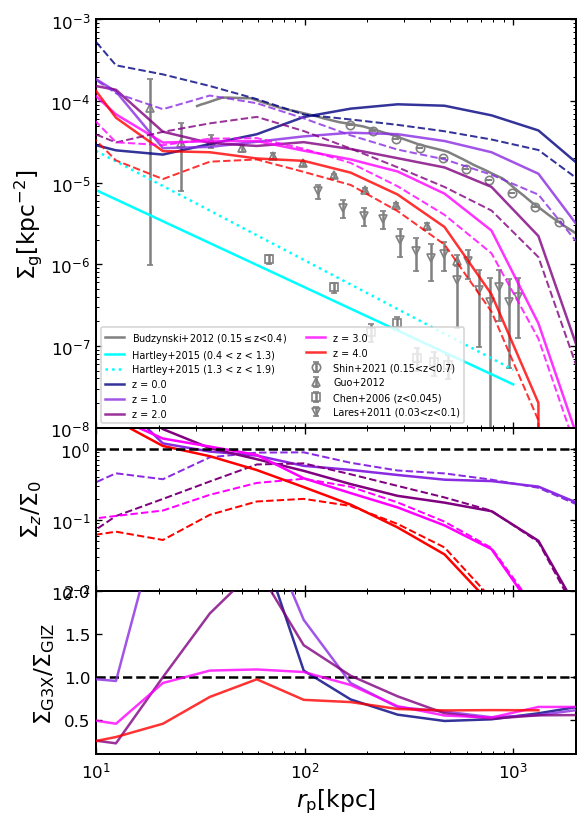

In [5]:
#Combined results
from astropy.cosmology import FlatLambdaCDM
plt.figure(figsize = (5,7), dpi = 120)
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.2 #set the value globally
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115)

#divide grids for figure

snapb = [128,96,78,65,55,47,40]
redb = ['z = 0.0','z = 1.0','z = 2.0','z = 3.0','z = 4.0','z = 5.0','z = 6.0']
# colall = ['b','r','k','orange','cyan','magenta','green']
colall = ['navy','blueviolet','purple','magenta','r','tomato','orange']
nGIZ = [324,324,323,323,323,318,306]
nG3X = [324,324,324,323,323,320,305]
#==========================================================

ob_Numgal(ax1)

# GIZMO
    if i == 0:
        xmed0,ymed0,yerr0 = cal_sta_profiles('GIZ',GIZd,snapb[i],'Subhalo_rr3D',False,nGIZ[i])
        ax1.plot(xmed0,ymed0,lw = 1.5, label = redb[i],c=colall[i],zorder = 20, alpha=0.8)
        # ax1.fill_between(xmed0, ymed0-yerr0, ymed0+yerr0, color = colall[i],alpha = 0.15, edgecolor = 'none')
        xmed0_x,ymed0_x,yerr0_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'Subhalo_rr3D',False,nG3X[i])
        ax1.plot(xmed0_x,ymed0_x,lw = 1.2, ls = '--',  c=colall[i], zorder = 30,alpha = 0.8)
        ax20.plot(xmed0_x,ymed0_x/ymed0, c=colall[i], zorder = 30,alpha = 0.8)

#==========================================================================
# ax10.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.axhline(1,c='k',ls='--')

ax1.set_ylabel(r'$\Sigma_{\rm g} [\rm kpc^{-2}]$', fontsize = 14)
ax1.loglog()
ax1.legend( ncol = 2, loc = 3, fontsize = 'xx-small')
ax1.set_xticklabels([])

ax1.set_ylim(1e-8,1e-3)
ax1.set_xlim(10,2e3)
# ax1.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.set_xscale('log')
ax10.set_xlim(10,2e3)
ax10.set_ylim(0.01,2)
ax10.set_yscale('log')
ax10.set_xticklabels([])
# ax10.set_xlabel(r'$r/r_{500}$', fontsize = 14)
ax10.set_ylabel(r'$\Sigma_z/\Sigma_0$', fontsize = 14)

ax20.axhline(1,c='k',ls='--')
ax20.set_xscale('log')
# ax20.set_yscale('log')
ax20.set_xlim(10,2e3)
ax20.set_ylim(0.1,2)

ax20.set_xlabel(r'$r_\mathrm{p}[\mathrm{kpc}]$', fontsize = 14)
ax20.set_ylabel(r'$\Sigma_{\rm G3X}/\Sigma_{\rm GIZ}$', fontsize = 14)
ax20.tick_params(top = 'on', right = 'on', which='both',direction = 'in',labelsize = 10)

ax1.tick_params(top = 'on', right = 'on', which='both',direction = 'in',labelsize = 10)
ax10.tick_params(top = 'on', right = 'on', which='both',direction = 'in',labelsize = 10)
# ax10.axis('off')

plt.tight_layout()
plt.subplots_adjust(wspace = 0, hspace = 0)
# plt.savefig('./figs/Numgal.pdf')

## testing

In [ ]:
def test():
    def gNFW(xx, alpha, c):
        from astropy.cosmology import FlatLambdaCDM
        cosmo = FlatLambdaCDM(H0 = 70, Om0 = 0.3)
        pc = cosmo.critical_density(0).to('Msun Mpc-3').value
        rho0 = pc*200 / c**alpha / (1 + c)**(3-alpha)
        b1 = (xx*c)**alpha
        b2 = (1 + xx * c)**(3-alpha)
        return rho0 / b1 / b2
    
    alpha = 1.64
    c = 0.72
    xx = np.logspace(-2,0,50)
    yy = gNFW(xx, alpha, c)
    plt.plot(xx,yy,'k-')
    
    v2015_m = np.loadtxt(open('./data/ob_Numgal/vdB+2015/med.csv', 'r'),delimiter = ',')
    v2015_t = np.loadtxt(open('./data/ob_Numgal/vdB+2015/up.csv', 'r'),delimiter = ',')
    v2015_b = np.loadtxt(open('./data/ob_Numgal/vdB+2015/bot.csv', 'r'),delimiter = ',')
    # plt.plot(v2015_m[:,0], v2015_m[:,1], 'r-')

KeyboardInterrupt: 

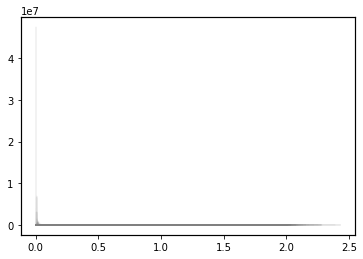

In [6]:
snapb = [128,96,78,65,55,47,40]
redb = ['z = 0.0','z = 1.0','z = 2.0','z = 3.0','z = 4.0','z = 5.0','z = 6.0']
nGIZ = [324,324,323,323,323,318,306]
#==========================================================
snap = 55
ntclu = 323
d = GIZd
#==========================================================

plt.figure()
#read raw data
region = 'Numgal'
nbin = 20

allvalue=np.zeros(shape = (ntclu,nbin))
rbinvalue=np.zeros(shape = (ntclu,nbin))
npvalue=np.zeros(shape = (ntclu,nbin))
i = 0
for nclu in range(324):
    if 'Rbin' not in d['NewMDCLUSTER_0%03d/snap_%03d'%(nclu+1, snap)]:     
        continue
    r500 = d['NewMDCLUSTER_%04d/snap_%03d'%(nclu+1,snap)].attrs['r500']
    r200 = d['NewMDCLUSTER_%04d/snap_%03d'%(nclu+1,snap)].attrs['r200']
    allvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/%s'%(nclu+1,snap,region)][0,:]
    rbins = np.logspace(np.log10(0.001*r200), np.log10(1.5*r200), num=20+1)
    rbinvalue[i] = (rbins[1:] + rbins[:-1])/2
    rbinvalue[i] /= r500 #unit: r/r200
        
    allvalue[i] = allvalue[i]  * 0.6777**3 * 1e9  #unit: Mpc^-3
    
    plt.plot(rbinvalue[i], allvalue[i], c = 'grey', alpha = 0.1)

    i+=1
    
xmed, ymed, yerr = cal_median(rbinvalue, allvalue, 20)
print(xmed)
print(ymed)
idx = ymed != 0
plt.plot(xmed[idx],ymed[idx],lw = 1.5, c='r',zorder = 500)
plt.fill_between(xmed,yerr[0,:],yerr[1,:],color ='r', zorder = 200, 
                 alpha = 0.15, edgecolor = 'none')
plt.title('z = 4.0')
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$n_{\rm gal}[\rm Mpc^{-3}]$', fontsize = 14)
plt.xlabel(r'$r/r_{500}$', fontsize = 14)

In [ ]:
#Combined results
from astropy.cosmology import FlatLambdaCDM
plt.figure(figsize = (5,7))
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.2 #set the value globally
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115)

#divide grids for figure
ax1 = plt.subplot2grid((9,4),(0,0),colspan = 4,rowspan = 5)
ax10 = plt.subplot2grid((9,4),(5,0),colspan = 4,rowspan = 2)
ax20 = plt.subplot2grid((9,4),(7,0),colspan = 4,rowspan = 2)

snapb = [128,96,78,65,55,47,40]
redb = ['z = 0.0','z = 1.0','z = 2.0','z = 3.0','z = 4.0','z = 5.0','z = 6.0']
# colall = ['b','r','k','orange','cyan','magenta','green']
colall = ['navy','blueviolet','purple','magenta','r','tomato','orange']
nGIZ = [324,324,323,323,323,318,306]
nG3X = [324,324,324,323,323,320,305]
#==========================================================

# ob_Numgal(ax1)

# GIZMO
#Gadget-X      
for i in [0,1,2,3]:
    if i == 0:
        xmed0,ymed0,yerr0 = cal_sta_profiles('GIZ',GIZd,snapb[i],'Numgal',False,nGIZ[i])
        xmed25,ymed25,yerr25 = cal_sta_profiles('GIZ',GIZd,snapb[i],'Numgal',True,nGIZ[i])
        idt = (yerr0[0] > 0)
        ax1.plot(xmed0[idt],ymed0[idt],lw = 1.5, label = redb[i],c=colall[i],zorder = 20, alpha=0.8)
        ax1.fill_between(xmed0[idt],yerr0[0,idt],yerr0[1,idt],color = colall[i],alpha = 0.15, edgecolor = 'none')
        
        xmed0_x,ymed0_x,yerr0_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'Numgal',False,nG3X[i])
        xmed25_x,ymed25_x,yerr25_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'Numgal',True,nG3X[i])
        idt_x = (yerr0_x[0] != 0)
        ax1.plot(xmed0_x[idt_x],ymed0_x[idt_x],lw = 1.2, ls = '--',  c=colall[i], zorder = 30,alpha = 0.8)
        
        ax20.plot(xmed0_x[idt_x],ymed0_x[idt_x]/ymed0[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
        
#         print('GIZ radius',xmed0[idt])
#         print('G3X radius',xmed0_x[idt_x])
        
    elif i <= 3:
        xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,snapb[i],'Numgal',False,nGIZ[i])
        idt = (yerr[0] > 0)
        ax1.plot(xmed[idt],ymed[idt],lw = 1.5, label = redb[i],c=colall[i],zorder = 20, alpha = 0.8)
        ax1.fill_between(xmed[idt],yerr[0,idt],yerr[1,idt],color = colall[i],alpha = 0.15, edgecolor = 'none')
        ax10.plot(xmed[idt],ymed[idt]/ymed0[idt],lw = 1.5, c=colall[i])
        
        xmed_x,ymed_x,yerr_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'Numgal',False,nG3X[i])
        idt_x = (yerr_x[0] != 0)
        ax1.plot(xmed_x[idt_x], ymed_x[idt_x], lw = 1.2, ls = '--', c=colall[i], zorder = 30, alpha = 0.8)
        ax10.plot(xmed_x[idt_x], ymed_x[idt_x]/ymed0_x[idt_x],c=colall[i], lw = 1.2, ls = '--')
        
        ax20.plot(xmed_x[idt_x],ymed_x[idt_x]/ymed[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
        
    else:
        xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,snapb[i],'Numgal',True,nGIZ[i])
        idt = (yerr[0] > 0)
        ax1.plot(xmed[idt],ymed[idt],lw = 1.5, label = redb[i],c=colall[i],zorder = 20, alpha = 0.8)
        ax1.fill_between(xmed[idt],yerr[0,idt],yerr[1,idt],color =colall[i],alpha = 0.15, edgecolor = 'none')
        ax10.plot(xmed[idt],ymed[idt]/ymed25[idt],lw = 1.5, c=colall[i])
        
        xmed_x,ymed_x,yerr_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'Numgal',True,nG3X[i])
        idt_x = (yerr_x[0] != 0)
        ax1.plot(xmed_x[idt_x], ymed_x[idt_x], lw = 1.2, ls = '--', c=colall[i], zorder = 30, alpha = 0.8)
        ax10.plot(xmed_x[idt_x], ymed_x[idt_x]/ymed25_x[idt_x], c=colall[i], lw = 1.2, ls = '--')
        
        ax20.plot(xmed_x[idt_x], ymed_x[idt_x]/ymed[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
        
#==========================================================================
# ax10.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.axhline(1,c='k',ls='--')

ax1.set_ylabel(r'$\Sigma_{\rm g} [\rm Mpc^{-2}]$', fontsize = 14)
ax1.loglog()
ax1.legend( ncol = 1, loc = 3, fontsize = 'x-small')
ax1.set_xticklabels([])

# ax1.set_ylim(1e1,2e7)
ax1.set_xlim(0.07,1)
# ax1.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.set_xscale('log')
ax10.set_xlim(0.07,1)
ax10.set_ylim(0.4,0.7)
# ax10.set_yscale('log')
ax10.set_xticklabels([])
# ax10.set_xlabel(r'$r/r_{500}$', fontsize = 14)
ax10.set_ylabel(r'$\Sigma_z/\Sigma_0$', fontsize = 14)

ax20.axhline(1,c='k',ls='--')
ax20.set_xscale('log')
# ax20.set_yscale('log')
ax20.set_xlim(0.07,1)
ax20.set_ylim(0.4,0.85)

ax20.set_xlabel(r'$r/r_{200}$', fontsize = 14)
ax20.set_ylabel(r'$\Sigma_{\rm G3X}/\Sigma_{\rm GIZ}$', fontsize = 14)
ax20.tick_params(top = 'on', right = 'on', which='both',direction = 'in',labelsize = 10)

ax1.tick_params(top = 'on', right = 'on', which='both',direction = 'in',labelsize = 10)
ax10.tick_params(top = 'on', right = 'on', which='both',direction = 'in',labelsize = 10)
# ax10.axis('off')

plt.tight_layout()
plt.subplots_adjust(wspace =0 ,hspace = 0)
# plt.savefig('./figs/Numgal.pdf')

In [ ]:
# for j in range(nbin):
#     idx = np.where((rrall >= rr[j]) & (rrall < rr[j+1]))[0]
#     seqsel = seqall[idx]
#     count_clu[j] = np.unique(seqsel).shape[0]

In [ ]:
def ob_Numgal(ax):
    # plt.figure(dpi = 120)
    #===========================================================
    # #Budzynski+2012, Fig.5, 14.7-15.0 halo mass
    B2012_r_m = np.loadtxt(open('./data/ob_Numgal/Budzynski+2012/B_r_m.csv', 'r'),delimiter = ',')
    B2012_err_down = np.loadtxt(open('./data/ob_Numgal/Budzynski+2012/B2012_err_down.csv', 'r'),delimiter = ',')
    B2012_err_med = np.loadtxt(open('./data/ob_Numgal/Budzynski+2012/B2012_err_med.csv', 'r'),delimiter = ',')
    B2012_err_up = np.loadtxt(open('./data/ob_Numgal/Budzynski+2012/B2012_err_up.csv', 'r'),delimiter = ',')

    from scipy.interpolate import interp1d
    f_fit = interp1d(B2012_r_m[:,0], B2012_r_m[:,1], kind= 'quadratic',fill_value="extrapolate")
    xx = B2012_err_med[:,0]
    yy = f_fit(B2012_err_med[:,0])
    yerr_down = np.log10(B2012_err_med[:,1])-np.log10(B2012_err_down[:,1])
    yerr_up = np.log10(B2012_err_up[:,1])-np.log10(B2012_err_med[:,1])
    
    ax.errorbar(xx, np.log10(yy), yerr = [yerr_down, yerr_up] ,
                c = 'grey',fmt = 'o',mfc = 'none', label = 'Budzynski+2012 (0.15$\leq$z<0.4)'
                 ,ms = 5, zorder = -1, capsize = 2)
    
    yerr_down = np.log10(B2012_err_med[:,1])-np.log10(B2012_err_down[:,1])
    yerr_up = np.log10(B2012_err_up[:,1])-np.log10(B2012_err_med[:,1])
    ax.errorbar(B2012_err_med[:,0], np.log10(B2012_err_med[:,1]), yerr = [yerr_down, yerr_up] ,
                c = 'grey',fmt = '^',mfc = 'none', label = 'Budzynski+2012 (0.15$\leq$z<0.4)'
                 ,ms = 5, zorder = -1, capsize = 2)
    
    # xz = np.logspace(1,3,100)
    # plt.plot(xz, f_fit(xz), 'r-')

    # xx = B2012_r_m[:,0] * 1e3 #kpc
    # yy = B2012_r_m[:,1] / 1e6 #kpc^-2
    # ax.plot(xx,yy,color = 'grey',label = 'Budzynski+2012 (0.15$\leq$z<0.4)')

plt.figure(dpi = 120)
ax = plt.gca()
ob_Numgal(ax)
plt.xscale('log')
plt.xlim(0.01,5)
plt.ylim(-1,2.1)



    
    